In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from PIL import Image
%matplotlib notebook

In [2]:
# load all images files from selected directory in ascending order and convert them to grayscale
img_dir = "videok7"
imgs = [i for i in os.listdir(img_dir) if i[-4:] == ".png" ]
imgs = sorted(imgs)
imgs = [cv2.cvtColor(cv2.imread(img_dir + "/" + i), cv2.COLOR_BGR2GRAY) for i in imgs if int(i[-9:-4]) in range(0, 200000)]

In [3]:
def match_frames(img, previous_img, template_width, template_height, offset_x, offset_y):
    # cut out template from old image
    template = previous_img[offset_x:offset_x+template_width, offset_y:offset_y+template_height]
    
    # match on current image# calculate number of required steps
    template_height, template_width = template.shape
    divisions = max(2 ** (np.floor(np.log2(min(template_width, template_height))) - 3), 1)
    
    # resize inputs for initial step
    img_small = cv2.resize(img, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
    template_small = cv2.resize(template, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
    dx, dy = 0, 0

    # first match
    match_img_small = cv2.matchTemplate(img_small, template_small, method=cv2.TM_SQDIFF_NORMED)
    dx, dy = np.unravel_index(np.argmin(match_img_small), match_img_small.shape)
    best = match_img_small[dx, dy]
    mean = np.mean(match_img_small)
    
    # iterate over remaining steps
    divisions //= 2
    while divisions >= 1:
        # rescale
        img_small = cv2.resize(img, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
        template_small = cv2.resize(template, (0, 0), fx=1./divisions, fy=1./divisions, interpolation=cv2.INTER_AREA)
        
        # adapt indices to new images and template (re)size
        dx *= 2
        dy *= 2
        
        # cut out image around previous match
        x_min = max(dx - 1, 0)
        x_max = min(dx + 2 + template_small.shape[0], img_small.shape[0] - 1)
        y_min = max(dy - 1, 0)
        y_max = min(dy + 2 + template_small.shape[1], img_small.shape[1] - 1)

        # ensure that size is big enough for template matching
        if y_max - y_min < template_small.shape[1] or x_max - x_min < template_small.shape[0]:
            return dx, dy, 1., 1. / mean
        
        # match
        match_img_small = cv2.matchTemplate(img_small[x_min:x_max, y_min:y_max], template_small, method=cv2.TM_SQDIFF_NORMED)
        max_idx = np.unravel_index(np.argmin(match_img_small), match_img_small.shape)
        
        # update displacement
        dx += max_idx[0] - 1
        dy += max_idx[1] - 1
        best = match_img_small[max_idx]
        
        divisions //= 2
    
    # remove offset
    dx -= offset_x
    dy -= offset_y
    
    return dx, dy, best, best / mean

def img_flow(imgs, template_width, template_height):
    # allocate output arrays
    u = [0]
    v = [0]
    best_matches = []
    snr = []
    
    # pre-calculate possible template offsets
    width, height = imgs[0].shape
    offset_x = width - template_width
    offset_y = height - template_height
    
    # initialize loop variables
    previous = imgs[0]
    
    # iterate over all images
    for i in range(1, len(imgs)):
        img = imgs[i]
        
        # match all corners
        dx_ul, dy_ul, best_ul, snr_ul = match_frames(img, previous, template_width, template_height, 0, 0)
        dx_ur, dy_ur, best_ur, snr_ur = match_frames(img, previous, template_width, template_height, offset_x, 0)
        dx_ll, dy_ll, best_ll, snr_ll = match_frames(img, previous, template_width, template_height, 0, offset_y)
        dx_lr, dy_lr, best_lr, snr_lr = match_frames(img, previous, template_width, template_height, offset_x, offset_y)
        
        # select best match
        best = np.argmin([best_ul, best_ur, best_ll, best_lr])
        if best == 0:
            dx, dy, best, current_snr = dx_ul, dy_ul, best_ul, snr_ul
        elif best == 1:
            dx, dy, best, current_snr = dx_ur, dy_ur, best_ur, snr_ur
        elif best == 2:
            dx, dy, best, current_snr = dx_ll, dy_ll, best_ll, snr_ll
        else:
            dx, dy, best, current_snr = dx_lr, dy_lr, best_lr, snr_lr
        
        # store relevant results
        u += [dy]
        v += [dx]
        best_matches += [best]
        snr += [current_snr]
        
        previous = img
        
    return u, v, best_matches, snr

In [4]:
t0 = time.perf_counter()
u, v, best, snr = img_flow(imgs, 50, 50)
t1 = time.perf_counter()
print(len(u) / (t1 - t0), "FPS")

387.99814623026845 FPS


<IPython.core.display.Javascript object>


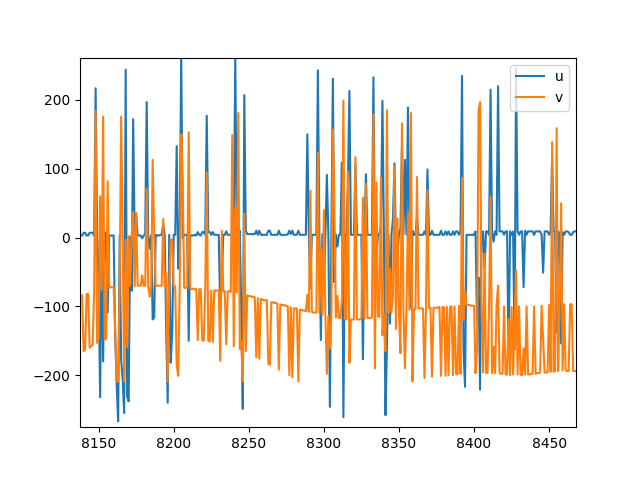

In [5]:
plt.figure()
plt.plot(np.array(u), label="u")
plt.plot(np.array(v), label="v")
# plt.plot(np.array(outliers)*100, label="outlier")
plt.legend()
plt.show()

In [6]:
def check_frameskip(x, prev_x):
    # only act when going above minimum speed
    if np.abs(prev_x) < 10 and np.abs(x) < 10:
        return 0
    
    # check for frame skip
    divider = prev_x
    if np.abs(x) < np.abs(prev_x):
        divider = x
        
    if divider == 0.:
        divider = 0.001
    
    dx = np.abs(float(x - prev_x) / divider)
    if dx > 0.95 and dx < 1.05 and np.sign(prev_x) == np.sign(x):
        return 1
    
    # check for physically implausible movement
    if dx > 0.3:
        return 4
    
    return 0

def remove_outliers(u, v, prev_u, prev_v, best, snr):
    frameskip_u = check_frameskip(u, prev_u)
    frameskip_v = check_frameskip(v, prev_v)
    
    # check for bad match
    if best > 0.3:
        return 3, prev_u, prev_v

    # check signal to noise ratio
    if snr > 0.3:
        return 2, prev_u, prev_v
    
    # check for physically implausible movement
    if frameskip_u == 4 or frameskip_v == 4:
        return 4, prev_u, prev_v
    
    # check for bad match
    if best > 0.2:
        return 3, prev_u, prev_v

    # check signal to noise ratio
    if snr > 0.3:
        return 2, prev_u, prev_v
    
    # check for frameskips
    if frameskip_u == 1 or frameskip_v == 1:
        return 1, u // 2, v // 2
    
    return 0, u, v

def filter_speed(u, b, best, snr):
    new_u = [u[0]]
    new_v = [v[0]]
    outliers = []
    for i in range(len(best)):
        outlier, new_u_current, new_v_current = remove_outliers(u[i+1], v[i+1], new_u[-1], new_v[-1], best[i], snr[i])
        new_u += [new_u_current]
        new_v += [new_v_current]
        outliers += [outlier]
        
        # duplicate result if frame was skipped
        if outlier == 1:
            new_u += [new_u_current]
            new_v += [new_v_current]
            outliers += [outlier]
        
    return outliers, new_u, new_v

In [7]:
t0 = time.perf_counter()
outliers, filtered_u, filtered_v = filter_speed(u, v, best, snr)
t1 = time.perf_counter()
print(len(filtered_u) / (t1 - t0), "FPS")

53309.917772142486 FPS


In [8]:
def median_filter(x, w):
    reshapable_x = x[:x.shape[0]-x.shape[0]%w]
    reshaped_x = reshapable_x.reshape((reshapable_x.shape[0]//w, w))
    return np.median(reshaped_x, axis=1) * w
final_u = median_filter(np.array(filtered_u), 5)
final_v = median_filter(np.array(filtered_v), 5)

<IPython.core.display.Javascript object>


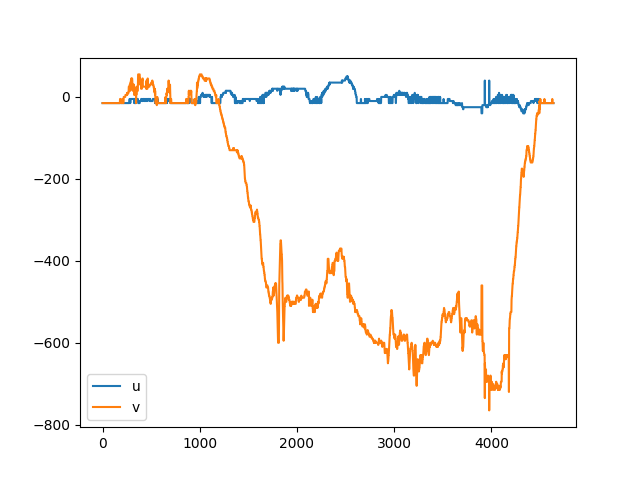

In [9]:
plt.figure()
plt.plot(final_u, label="u")
plt.plot(final_v, label="v")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


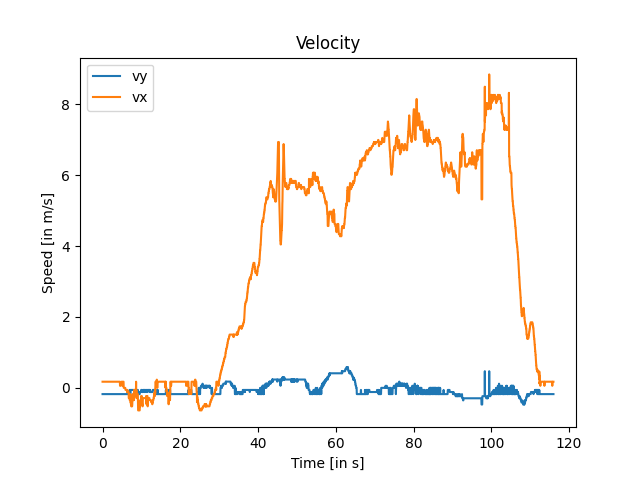

In [10]:
plt.figure()
# plt.plot(np.arange(0, (len(filtered_u) - 1) / 200, 1 / 200.), np.array(outliers), label="outlier")
plt.plot(np.arange(0, len(final_u) / (200//5), 1 / (200./5)), np.array(final_u) * 0.094 / 320. * (200./5), label="vy")
plt.plot(np.arange(0, len(final_u) / (200//5), 1 / (200./5)), -np.array(final_v) * 0.074 / 256. * (200./5), label="vx")
plt.xlabel("Time [in s]")
plt.ylabel("Speed [in m/s]")
plt.title("Velocity")
plt.legend()
plt.show()